In [8]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data, save_for_evaluation, process_train_test_data
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel


os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Data preparation

label
other-minor                 9805
meniskus-urgent             9312
cruciate-ligament-urgent    2388
meniskus-minor              1664
cruciate-ligament-minor      355
Name: count, dtype: int64


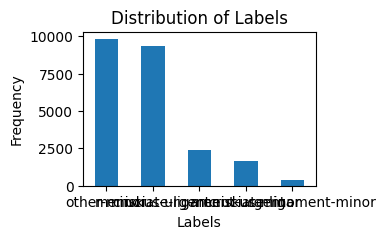

In [9]:
data_label = "data"
predict_label = "label"
balanced = False
labels = None
class_weights = False
sample_weights = False
df_train = pd.read_csv('../data/data_train.csv')
df_valid = pd.read_csv('../data/data_valid.csv')
df_test = pd.read_csv('../data/data_test.csv')

train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = process_train_test_data(df_train, df_valid, df_test, data_label, predict_label, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

# Model parameters

In [10]:
model_name = "tuner_l1"

In [11]:
from utils import get_standard_parameters

optimizer, loss, metrics, early_stopping_callback, embedding_dim, lstm_units, epochs, batch_size = get_standard_parameters()

# Model definition and training

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner import HyperModel, Hyperband
from tensorflow.keras.regularizers import l1_l2

import keras_tuner

class LSTMHyperModel(HyperModel):

    def build(self, hp):
        l1_1 = hp.Float('l1_1', min_value=0.0001, max_value=0.007, step=0.0001)
        l1_2 = hp.Float('l1_2', min_value=0.0001, max_value=0.007, step=0.0001)
        l2_1 = hp.Float('l2_1', min_value=0.0001, max_value=0.007, step=0.0001)
        l2_2 = hp.Float('l2_2', min_value=0.0001, max_value=0.007, step=0.0001)
        # Define the input layer
        input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

        # Embedding layer
        embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

        # Two LSTM layers with L1 and L2 regularization
        x = Bidirectional(LSTM(units=lstm_units, return_sequences=True, kernel_regularizer=l1_l2(l1_1, l2_1)))(embedding)
        x = Bidirectional(LSTM(units=lstm_units, kernel_regularizer=l1_l2(l1_2, l2_2)))(x)

        # Output layer
        output = Dense(num_classes, activation='softmax')(x)

        # Define the model
        model = Model(inputs=input_text, outputs=output)

        # Compile the model
        model.compile(optimizer='adam', loss=loss, metrics=metrics)
        
        return model

# Set up the tuner with the RandomSearch algorithm
tuner = Hyperband(
    LSTMHyperModel(),
    objective=keras_tuner.Objective("val_f1_score", "max"),
    hyperband_iterations=10,
    executions_per_trial=1,
    directory='model_tuning',
    project_name='LSTM_Regularization'
)

# Search for the best hyperparameters
tuner.search(train_padded, train_labels, epochs=4, validation_data=(valid_padded, valid_labels), callbacks=[early_stopping_callback])

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters found:")
for hp in best_hps.space:
    print(f"{hp.name}: {best_hps.get(hp.name)}")

Trial 28 Complete [00h 04m 39s]
val_f1_score: 0.24145154654979706

Best val_f1_score So Far: 0.24145154654979706
Total elapsed time: 02h 09m 44s

Search: Running Trial #29

Value             |Best Value So Far |Hyperparameter
0.0001            |0.0001            |l1_1
0.005             |0.0005            |l1_2
0.0046            |0.0033            |l2_1
0.0069            |0.0011            |l2_2
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
393/736 ━━━━━━━━━━━━━━━━━━━━ 56s 165ms/step - accuracy: 0.4328 - auc: 0.8004 - f1_score: 0.2297 - loss: 9.4506

KeyboardInterrupt: 

In [ ]:
tuner.results_summary()

Results summary
Results in model_tuning/LSTM_Regularization
Showing 10 best trials
Objective(name="val_f1_score", direction="max")

Trial 00 summary
Hyperparameters:
l1_1: 0.006
l1_2: 0.001
l2_1: 0.0061
l2_2: 0.004900000000000001
Score: 0.11768517643213272

Trial 01 summary
Hyperparameters:
l1_1: 0.0013000000000000002
l1_2: 0.0025
l2_1: 0.0024
l2_2: 0.0022
Score: 0.11768517643213272

Trial 02 summary
Hyperparameters:
l1_1: 0.0005
l1_2: 0.0045000000000000005
l2_1: 0.0047
l2_2: 0.0017000000000000001
Score: 0.11768517643213272

Trial 03 summary
Hyperparameters:
l1_1: 0.0051
l1_2: 0.004600000000000001
l2_1: 0.006900000000000001
l2_2: 0.006
Score: 0.11768517643213272

Trial 04 summary
Hyperparameters:
l1_1: 0.0004
l1_2: 0.0058000000000000005
l2_1: 0.0026
l2_2: 0.004600000000000001
Score: 0.11768517643213272

Trial 05 summary
Hyperparameters:
l1_1: 0.0041
l1_2: 0.0028
l2_1: 0.0015
l2_2: 0.0023
Score: 0.11768517643213272

Trial 06 summary
Hyperparameters:
l1_1: 0.006300000000000001
l1_2: 0.00

In [ ]:
save_for_evaluation(best_model, history, model_name, test_padded, test_labels, label_encoder)

NameError: name 'history' is not defined

In [ ]:
#eval_training(history, metrics)

In [ ]:
eval(best_model, test_padded, test_labels, label_encoder)

In [ ]:
160               |224               |embedding_dim
128               |64                |units
0.7               |0                 |dropout_1
0.8               |0.1               |dropout_2

In [ ]:
# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=224)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=64, return_sequences=True))(embedding)
x = Dropout(0)(x)
x = Bidirectional(LSTM(units=64))(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history = model.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels), callbacks=[early_stopping_callback])

In [ ]:
save_for_evaluation(best_model, history, model_name, test_padded, test_labels, label_encoder)

In [ ]:
eval(best_model, test_padded, test_labels, label_encoder)

In [ ]:
eval_training(history, metrics)